In [1]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 28.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

## Fresno County (Top Agricultural County in U.S.)

## Data Preprocessing

### Check Stationary

In [3]:
def check_stationarity(timeseries):
    # Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')

### SPEI-1 Data Processing

##### Load Data

In [94]:
df = pd.read_csv("/content/SPEI_1_MonthTimescale_1950_2013_Fresno_County.csv")
spei_1_df = df[['time', 'spei']]
spei_1_df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d')
spei_1_df.set_index('time', inplace=True)
spei_1_df.head()

<ipython-input-94-8b600326cea0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spei_1_df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d')


,spei
time,
1950-01-16,0.568691
1950-02-15,-0.323044
1950-03-16,-0.148050
1950-04-16,-0.585959
1950-05-16,-0.860067


##### Load Data V2 (Setting correct frequency)

In [98]:
df = pd.read_csv("/content/SPEI_1_MonthTimescale_1950_2013_Fresno_County.csv")
spei_1_df = df[['time', 'spei']]
spei_1_df['time'] = pd.to_datetime(spei_1_df['time'], format='%Y-%m-%d')
spei_1_df.set_index('time', inplace=True)

# align timestamps to the nearest start of the month to avoid NaNs (january 1, february 1, etc.)
spei_1_df.index = spei_1_df.index.to_period('M').to_timestamp()  # round dates to the start of the month

spei_1_df.head()

<ipython-input-98-52c284be5d6a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spei_1_df['time'] = pd.to_datetime(spei_1_df['time'], format='%Y-%m-%d')


,spei
time,
1950-01-01,0.568691
1950-02-01,-0.323044
1950-03-01,-0.148050
1950-04-01,-0.585959
1950-05-01,-0.860067


##### Data Insights

In [99]:
spei_1_df.min(), spei_1_df.max()

(spei   -2.472218
 dtype: float64,
 spei    2.70093
 dtype: float64)

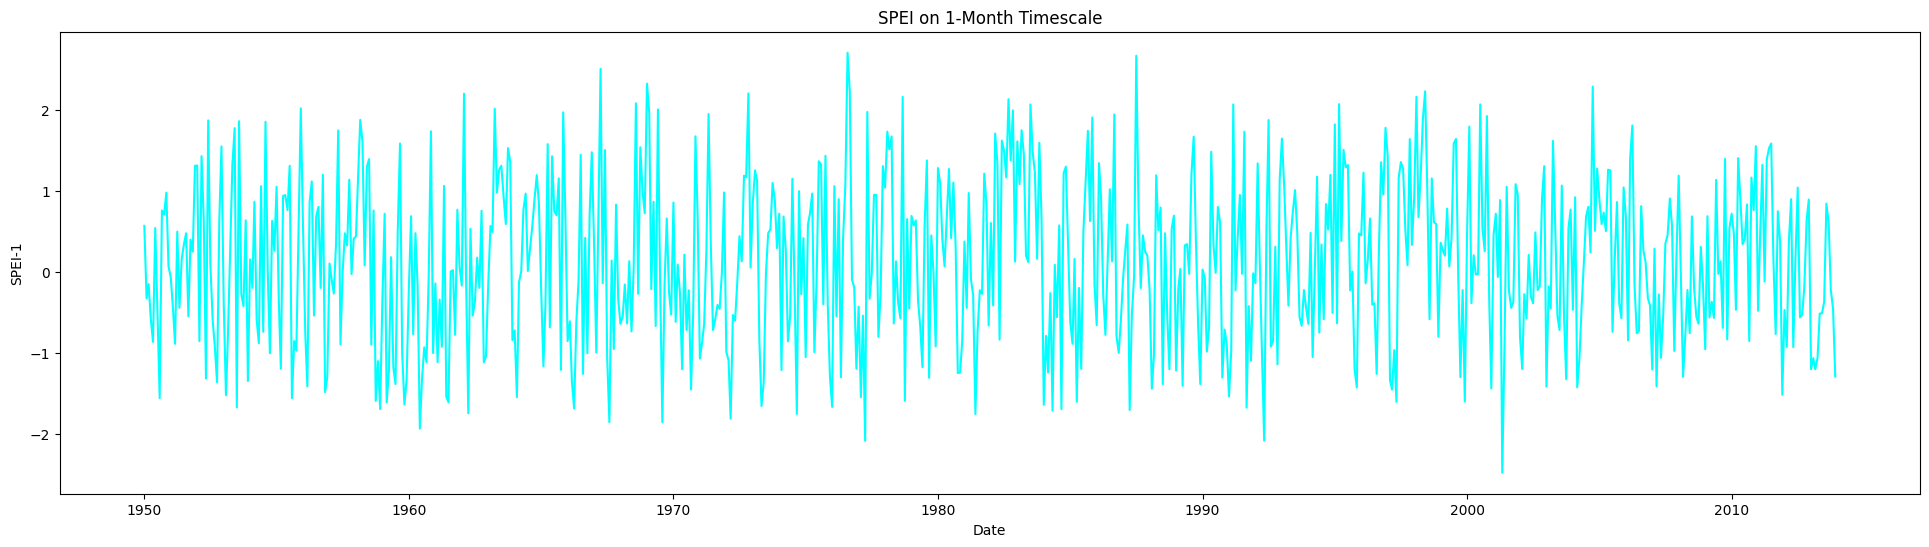

<Figure size 1800x600 with 0 Axes>

In [100]:
plt.figure(figsize=(24, 6))
plt.plot(spei_1_df['spei'], c='cyan')
plt.title("SPEI on 1-Month Timescale")
plt.xlabel("Date")
plt.ylabel("SPEI-1")
plt.figure(figsize=(18, 6))
plt.show()

In [8]:
# check if data is stationary
check_stationarity(spei_1_df['spei'])

ADF Statistic: -5.459315520159876
p-value: 2.539577460234558e-06
Stationary


##### Data Splits

In [9]:
train_spei1_df, test_spei1_df = train_test_split(spei_1_df, test_size=0.2, shuffle=False) # shuffle is False for time series data

print(f"Train data shape: {train_spei1_df.shape}")
print(f"Test data shape: {test_spei1_df.shape}")

Train data shape: (614, 1)
Test data shape: (154, 1)


### SPEI-6 Data Processing

##### Load Data

In [10]:
df = pd.read_csv("/content/SPEI_6_MonthTimescale_1950_2013_FresnoCORRECT.csv")
spei_6_df = df[['time', 'spei']]
spei_6_df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d')
spei_6_df.set_index('time', inplace=True)
spei_6_df.head()

<ipython-input-10-95928e58e9b3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spei_6_df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d')


,spei
time,
1950-01-16,-0.177393
1950-02-15,-0.520186
1950-03-16,-0.425508
1950-04-16,-0.482449
1950-05-16,-0.595851


##### Load Data V2 (Setting correct frequency)

In [11]:
spei_6_df = pd.read_csv("/content/SPEI_6_MonthTimescale_1950_2013_FresnoCORRECT.csv")
spei_6_df = spei_6_df[['time', 'spei']]
spei_6_df['time'] = pd.to_datetime(spei_6_df['time'], format='%Y-%m-%d')
spei_6_df.set_index('time', inplace=True)

# align timestamps to the nearest start of the month to avoid NaNs (january 1, february 1, etc.)
spei_6_df.index = spei_6_df.index.to_period('M').to_timestamp()  # round dates to the start of the month

spei_6_df.head()

,spei
time,
1950-01-01,-0.177393
1950-02-01,-0.520186
1950-03-01,-0.425508
1950-04-01,-0.482449
1950-05-01,-0.595851


##### Data Insights

In [12]:
spei_6_df.min(), spei_6_df.max()

(spei   -2.183273
 dtype: float64,
 spei    2.664024
 dtype: float64)

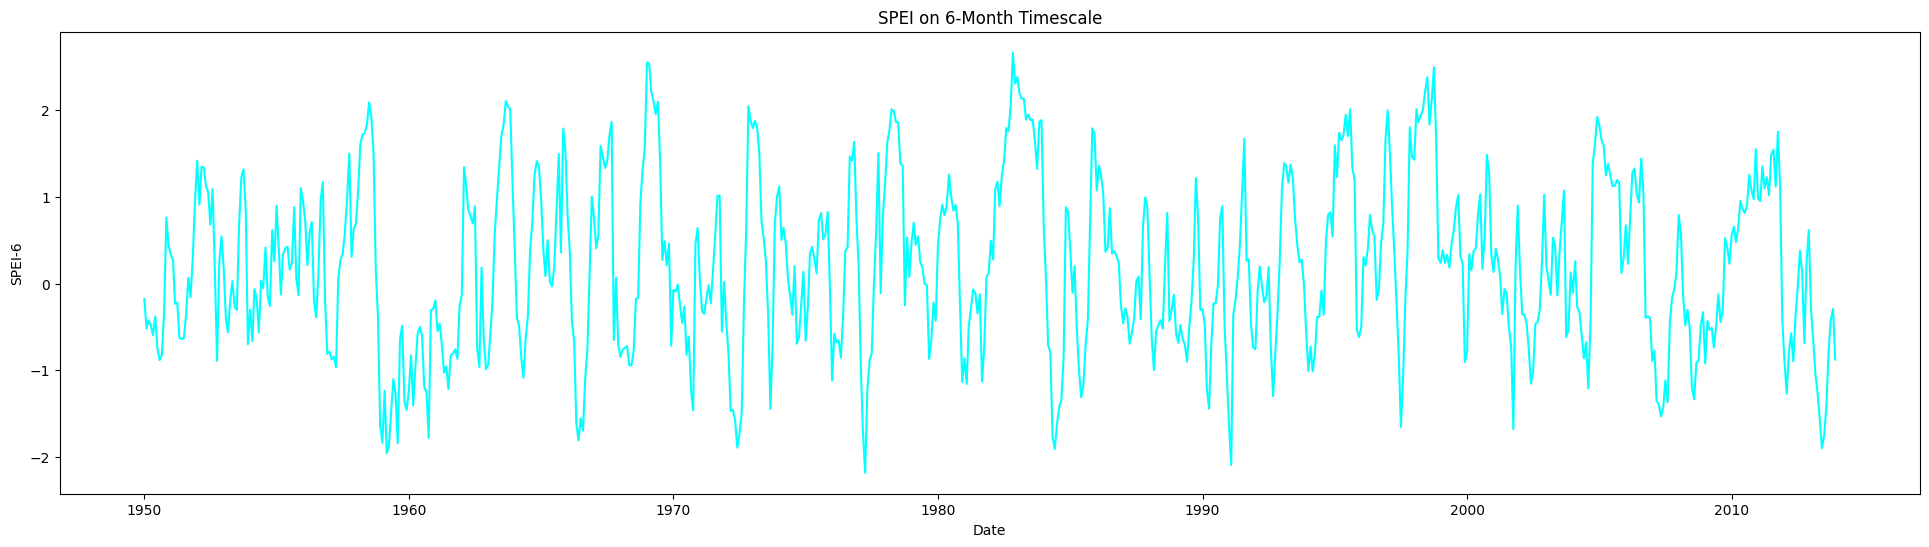

<Figure size 1800x600 with 0 Axes>

In [13]:
plt.figure(figsize=(24, 6))
plt.plot(spei_6_df['spei'], c='cyan')
plt.title("SPEI on 6-Month Timescale")
plt.xlabel("Date")
plt.ylabel("SPEI-6")
plt.figure(figsize=(18, 6))
plt.show()

In [14]:
# check if data is stationary
check_stationarity(spei_6_df['spei'])

ADF Statistic: -5.459315520159876
p-value: 2.539577460234558e-06
Stationary


<Figure size 1000x800 with 0 Axes>

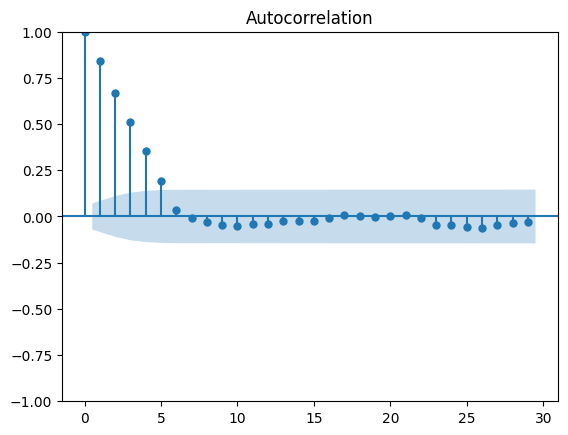

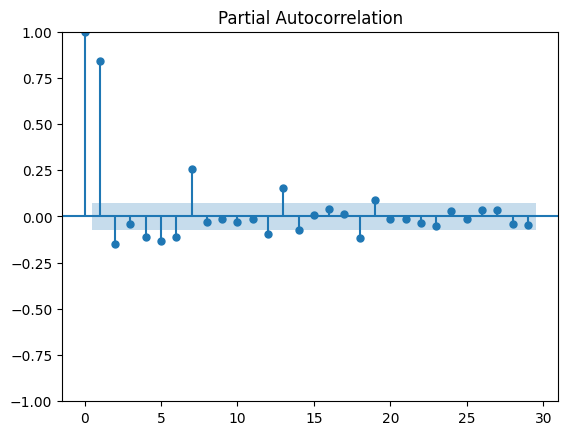

In [15]:
# plot ACF and PACF
plt.figure(figsize=(10, 8))
plot_acf(spei_6_df['spei'])
plot_pacf(spei_6_df['spei'])
plt.show()

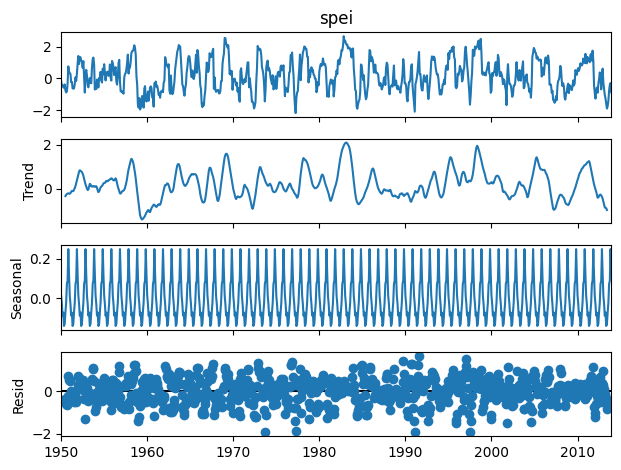

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(spei_6_df['spei'], model='additive', period=12)
decomposition.plot()
plt.show()

##### Data Splits

In [18]:
train_spei6_df, test_spei6_df = train_test_split(spei_6_df, test_size=0.2, shuffle=False) # shuffle is False for time series data

print(f"Train data shape: {train_spei6_df.shape}")
print(f"Test data shape: {test_spei6_df.shape}")

Train data shape: (614, 1)
Test data shape: (154, 1)


### SPEI-12 Data Processing

##### Load Data

In [80]:
df = pd.read_csv("/content/SPEI_12_MonthTimescale_1950_2013_Fresno.csv")
spei_12_df = df[['time', 'spei']]
spei_12_df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d')
spei_12_df.set_index('time', inplace=True)
spei_12_df.head()

<ipython-input-80-71520669a646>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spei_12_df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d')


,spei
time,
1950-01-16,-0.291648
1950-02-15,-0.343679
1950-03-16,-0.756500
1950-04-16,-0.402883
1950-05-16,-0.857081


##### Load Data V2 (Setting correct frequency)

In [82]:
spei_12_df = pd.read_csv("/content/SPEI_12_MonthTimescale_1950_2013_Fresno.csv")
spei_12_df = spei_12_df[['time', 'spei']]
spei_12_df['time'] = pd.to_datetime(spei_12_df['time'], format='%Y-%m-%d')
spei_12_df.set_index('time', inplace=True)

# align timestamps to the nearest start of the month to avoid NaNs (january 1, february 1, etc.)
spei_12_df.index = spei_12_df.index.to_period('M').to_timestamp()  # round dates to the start of the month

spei_12_df.head()

,spei
time,
1950-01-01,-0.291648
1950-02-01,-0.343679
1950-03-01,-0.756500
1950-04-01,-0.402883
1950-05-01,-0.857081


##### Data Insights

In [83]:
spei_12_df.min(), spei_12_df.max()

(spei   -2.160193
 dtype: float64,
 spei    2.851205
 dtype: float64)

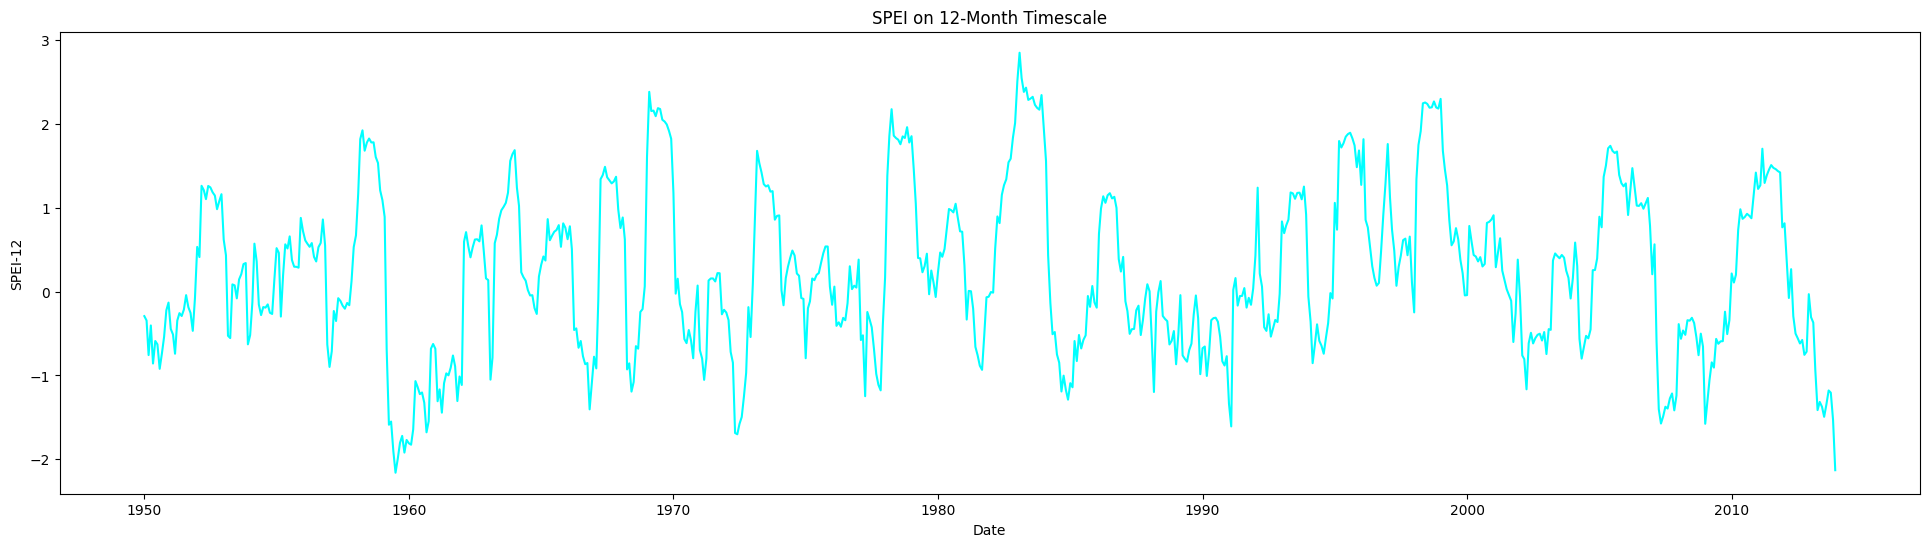

<Figure size 1800x600 with 0 Axes>

In [84]:
plt.figure(figsize=(24, 6))
plt.plot(spei_12_df['spei'], c='cyan')
plt.title("SPEI on 12-Month Timescale")
plt.xlabel("Date")
plt.ylabel("SPEI-12")
plt.figure(figsize=(18, 6))
plt.show()

In [85]:
# check if data is stationary
check_stationarity(spei_12_df['spei'])

ADF Statistic: -4.9072875881812275
p-value: 3.375298962652116e-05
Stationary


<Figure size 1000x800 with 0 Axes>

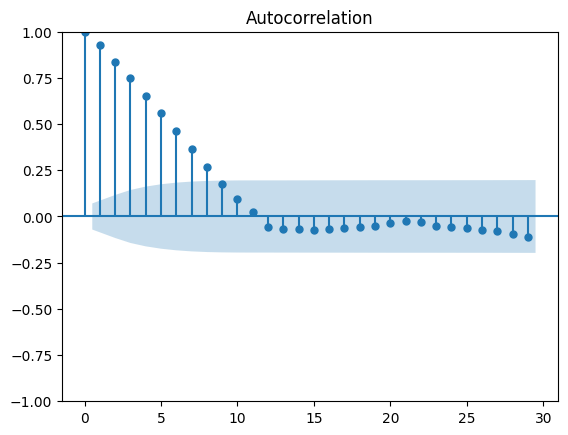

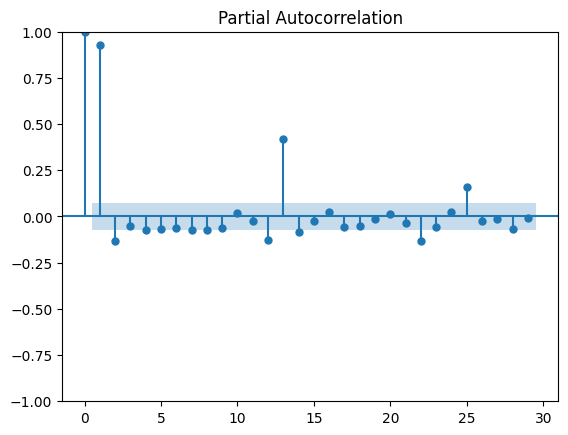

In [86]:
# plot ACF and PACF
plt.figure(figsize=(10, 8))
plot_acf(spei_12_df['spei'])
plot_pacf(spei_12_df['spei'])
plt.show()

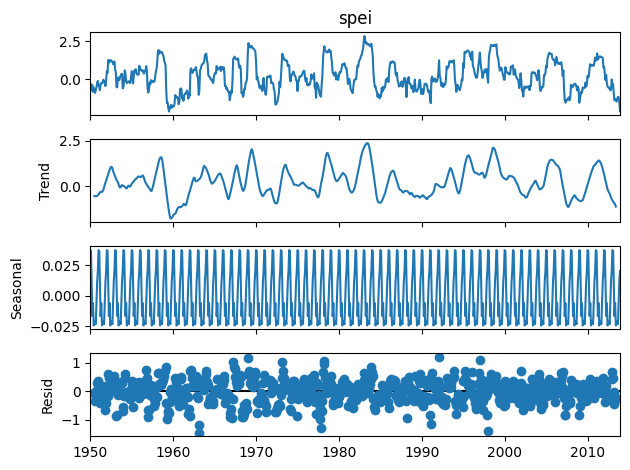

In [87]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(spei_12_df['spei'], model='additive', period=12)
decomposition.plot()
plt.show()

##### Data Splits

In [102]:
train_spei12_df, test_spei12_df = train_test_split(spei_12_df, test_size=0.2, shuffle=False) # shuffle is False for time series data

print(f"Train data shape: {train_spei12_df.shape}")
print(f"Test data shape: {test_spei12_df.shape}")

Train data shape: (614, 1)
Test data shape: (154, 1)


### Plotting all SPEI timescale trends

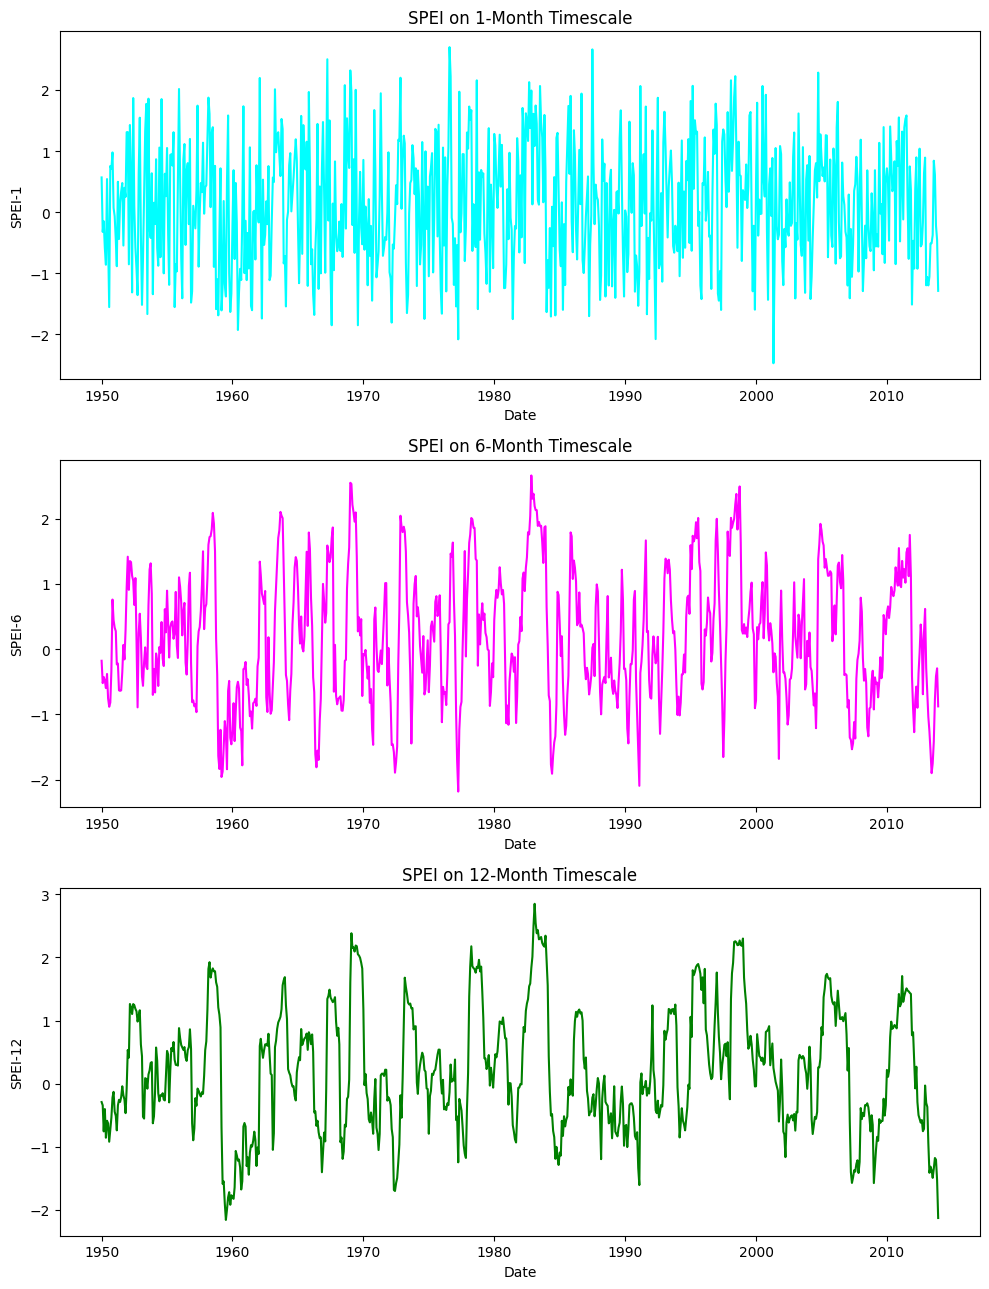

In [101]:
fig, axes = plt.subplots(3, 1, figsize=(10, 13))  # 3 rows, 1 column

# spei-1
axes[0].plot(spei_1_df['spei'], c='cyan')
axes[0].set_title("SPEI on 1-Month Timescale")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("SPEI-1")

# spei-6
axes[1].plot(spei_6_df['spei'], c='magenta')
axes[1].set_title("SPEI on 6-Month Timescale")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("SPEI-6")

# spei-12
axes[2].plot(spei_12_df['spei'], c='green')
axes[2].set_title("SPEI on 12-Month Timescale")
axes[2].set_xlabel("Date")
axes[2].set_ylabel("SPEI-12")

plt.tight_layout()
plt.show()

## ARIMA Model | SPEI-6

### Model Fitting
3 ways of finding best model parameters:
* manual
* auto_arima
  * allows us to find parameters automatically and faster
  * NOTE: uses approximation to speed up calculations so theres a chance it gives suboptimal model parameters
* grid search
  * iterate through all combinations of parameters
  * fit each SARIMA model with chosen parameters and compare based on evaluaton metric (AIC)

In [ ]:
from pmdarima import auto_arima

# auto find ARIMA parameters
auto_model_arimaSPEI6 = auto_arima(
    spei_6_df['spei'],
    m=12,  # 12 for monthly data
    error_action ='ignore',   # we don't want to know if an order does not work
    suppress_warnings=True,
    stepwise=True
)

# show the best parameters found
print(auto_model_arimaSPEI6.summary())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

KeyboardInterrupt: 

In [ ]:
best_arimaSPEI6_order = auto_model_arimaSPEI6.order
print("Best Order:", best_arimaSPEI6_order)

Best Order: (4, 0, 3)


In [ ]:
# values from auto-arima
# p, d, q = 4, 0, 3

# manually choosing params
p, d, q = 1, 0, 2

arima_spei6_model = ARIMA(
    train_spei6_df['spei'],
    order=(p, d, q),
    enforce_stationarity=True,
    enforce_invertibility=True
)
# arima_spei6_results = arima_spei6_model.fit()
arima_spei6_results = arima_spei6_model.fit(method_kwargs={"maxiter": 500})

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


### Model Evaluation

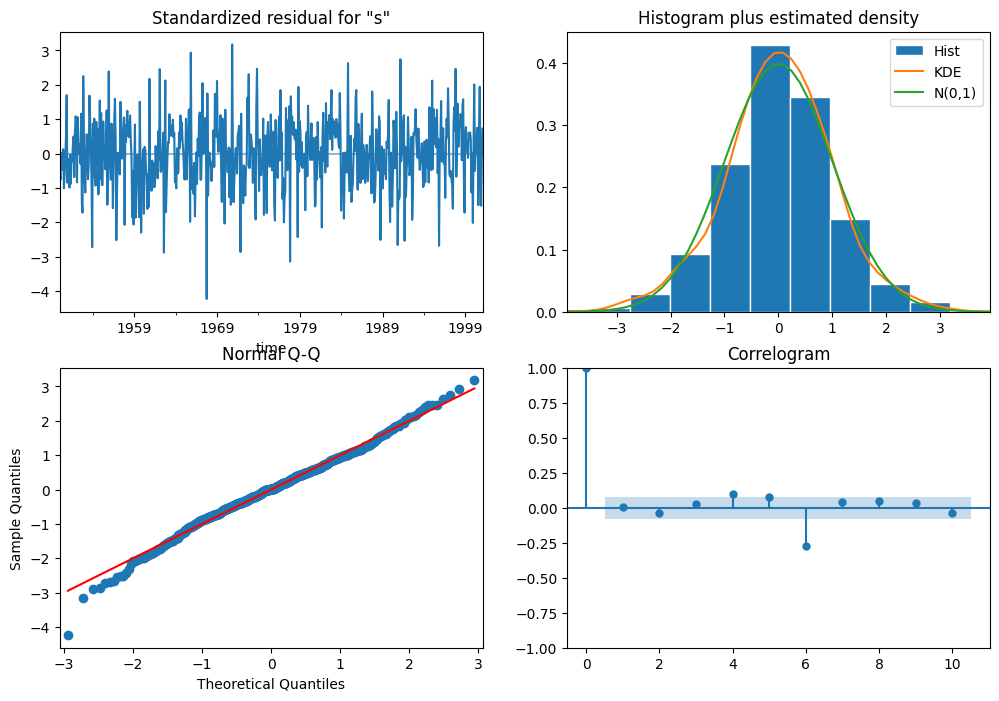

In [ ]:
arima_spei6_results.plot_diagnostics(figsize=(12, 8))
plt.show()

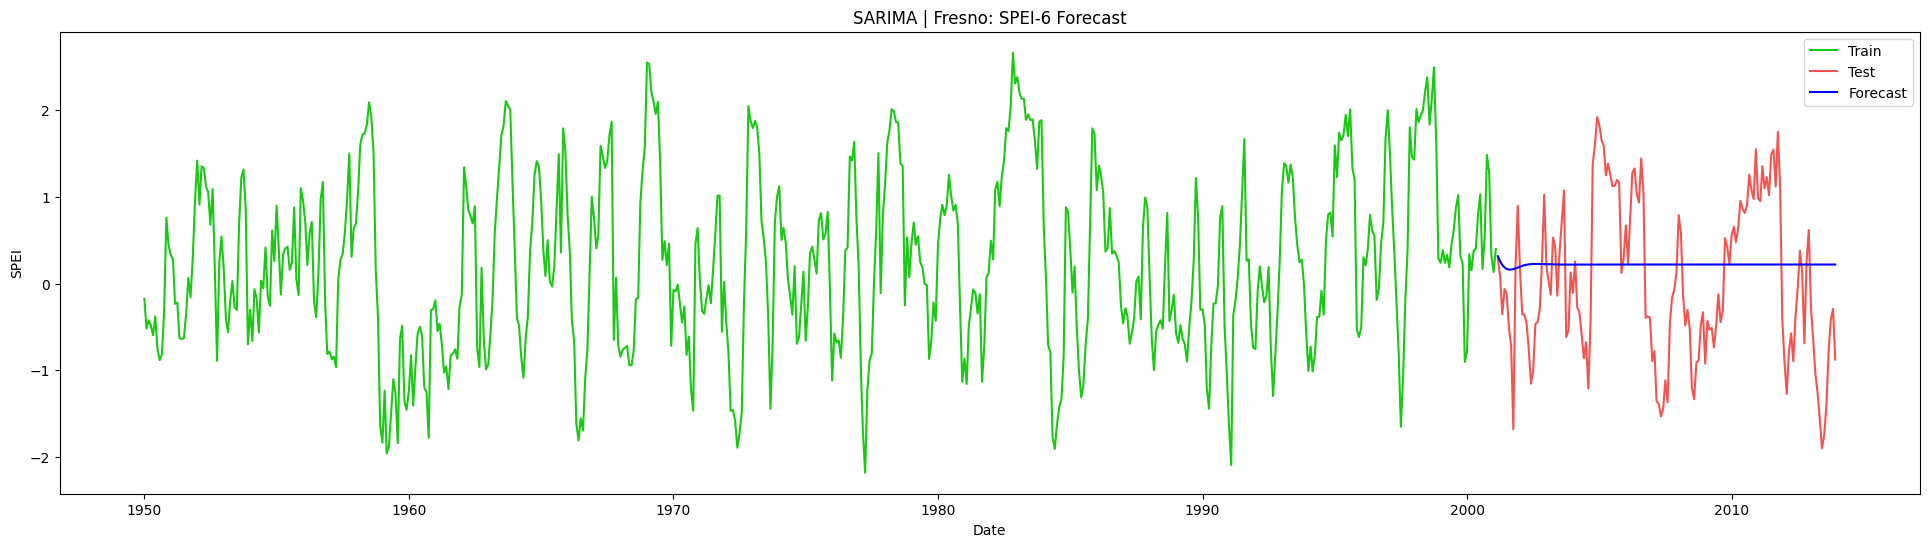

In [ ]:
# forecast
forecast = arima_spei6_results.forecast(steps=len(test_spei6_df))

# Plot the results with specified colors
plt.figure(figsize=(24,6))
plt.plot(train_spei6_df.index, train_spei6_df['spei'], label='Train', color='#1AC914')
plt.plot(test_spei6_df.index, test_spei6_df['spei'], label='Test', color='#F45451')
plt.plot(test_spei6_df.index, forecast, label='Forecast', color='b')
plt.title('SARIMA | Fresno: SPEI-6 Forecast')
plt.xlabel('Date')
plt.ylabel('SPEI')
plt.legend()
plt.show()

In [ ]:
mse = mean_squared_error(test_spei6_df['spei'], forecast)
mae = mean_absolute_error(test_spei6_df['spei'], forecast)
rmse = np.sqrt(mse)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

## SARIMA Model | SPEI-1

### Model Fitting
3 ways of finding best model parameters:
* manual
* auto_arima
  * allows us to find parameters automatically and faster
  * NOTE: uses approximation to speed up calculations so theres a chance it gives suboptimal model parameters
* grid search
  * iterate through all combinations of parameters
  * fit each SARIMA model with chosen parameters and compare based on evaluaton metric (AIC)

In [20]:
# SARIMA parameters
p, d, q = 1, 0, 1
P, D, Q, s = 1, 0, 1, 12  # Assuming monthly seasonality

# fit the SARIMA model to train data
model = SARIMAX(train_spei1_df['spei'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_spei1_results = model.fit()
model

NameError: name 'train_df' is not defined

In [ ]:
sarima_spei1_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               spei   No. Observations:                  614
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -876.328
Date:                            Fri, 28 Feb 2025   AIC                           1762.657
Time:                                    06:29:31   BIC                           1784.757
Sample:                                         0   HQIC                          1771.251
                                            - 614                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4235      0.178      2.373      0.018       0.074       0.773
ma.L1         -0.2492      0.191     -1.303      0.193      -0.624       0.126
ar.S.L12       0.9661      0.121      7.988      0.000       0.729       1.203
ma.S.L12      -0.9527      0.136     -6.999      0.000      -1.219      -0.686
sigma2         1.0161      0.073     13.944      0.000       0.873       1.159
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                14.45
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.04
Prob(H) (two-sided):                  0.89   Kurtosis:                         2.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


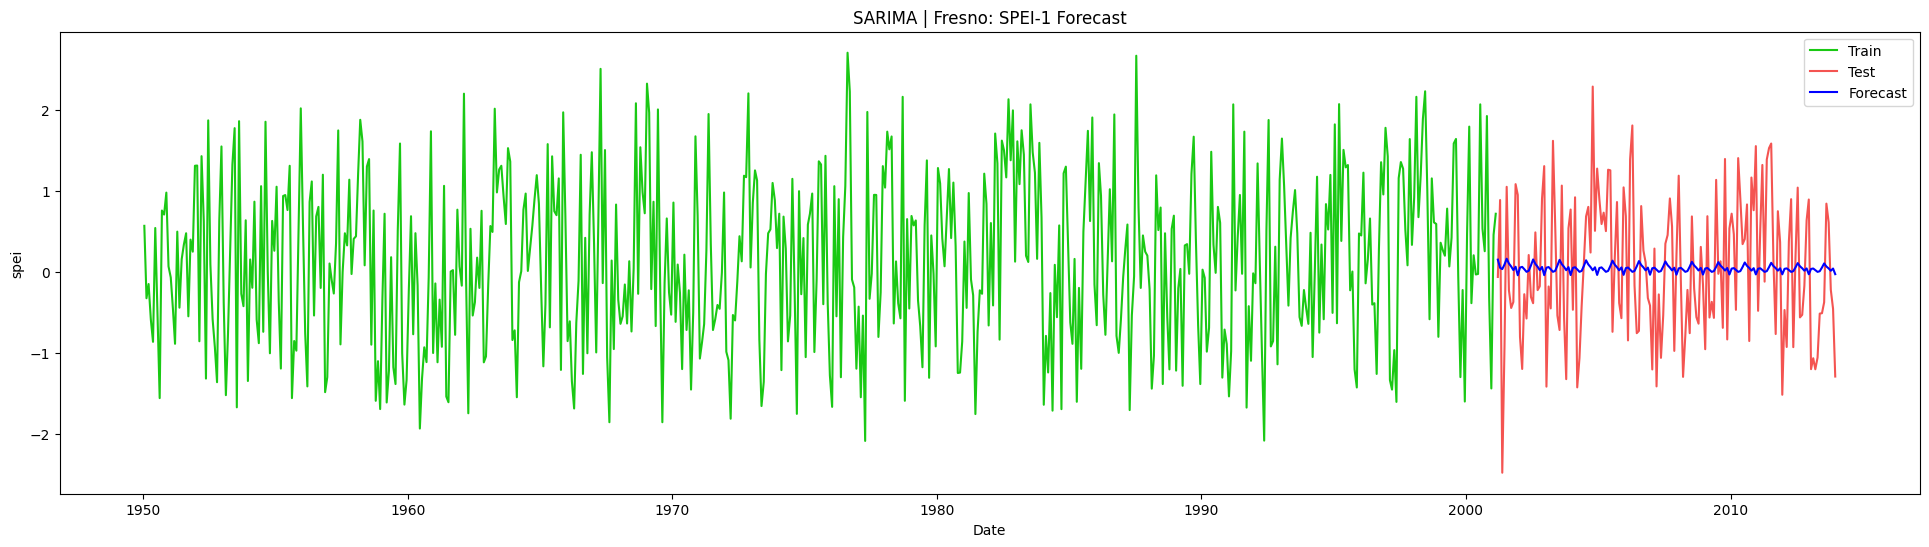

In [ ]:
# Forecast
sarima_spei1_forecast = sarima_spei1_results.forecast(steps=len(test_spei1_df))

# Plot the results with specified colors
plt.figure(figsize=(24,6))
plt.plot(train_spei1_df.index, train_spei1_df['spei'], label='Train', color='#1AC914')
plt.plot(test_spei1_df.index, test_spei1_df['spei'], label='Test', color='#F45451')
plt.plot(test_spei1_df.index, sarima_spei1_forecast, label='Forecast', color='b')
plt.title('SARIMA | Fresno: SPEI-1 Forecast')
plt.xlabel('Date')
plt.ylabel('spei')
plt.legend()
plt.show()

### Model Evaluation

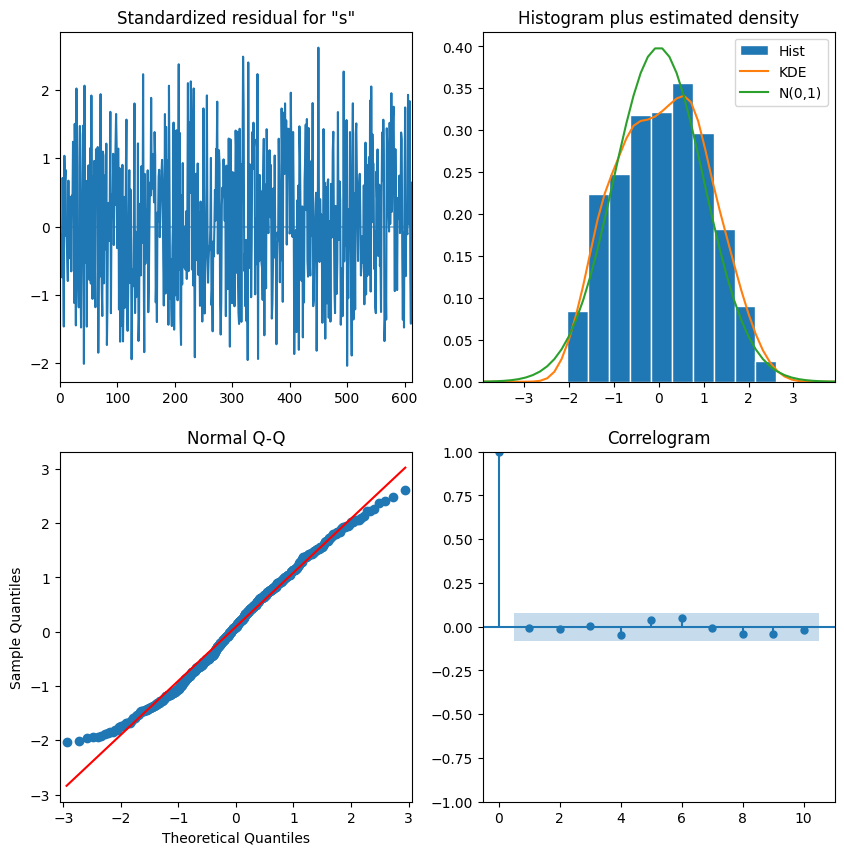

In [ ]:
sarima_spei1_results.plot_diagnostics(figsize=(10, 10))
plt.show()

In [ ]:
mse = mean_squared_error(test_spei1_df['spei'], forecast)
mae = mean_absolute_error(test_spei1_df['spei'], forecast)
rmse = np.sqrt(mse)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Squared Error (MSE): 0.7337591070295785
Mean Absolute Error (MAE): 0.7329742579970002
Root Mean Squared Error (RMSE): 0.8565974007838095


In [ ]:
print(f"AIC: {sarima_spei1_results.aic}")
print(f"BIC: {sarima_spei1_results.bic}")

AIC: 1762.6566255174598
BIC: 1784.7566001581956


## SARIMA Model | SPEI-6

### Model Fitting
3 ways of finding best model parameters:
* manual
* auto_arima
  * allows us to find parameters automatically and faster
  * NOTE: uses approximation to speed up calculations so theres a chance it gives suboptimal model parameters
* grid search
  * iterate through all combinations of parameters
  * fit each SARIMA model with chosen parameters and compare based on evaluaton metric (AIC)

In [21]:
# using auto_arima to automatically find optimal SARIMA parameters

from pmdarima import auto_arima

auto_model_sarima_spei6 = auto_arima(
    spei_6_df['spei'],
    seasonal=True,
    m=12,  # 12 for monthly data
    error_action ='ignore',   # we don't want to know if an order does not work
    suppress_warnings=True,
    stepwise=True
)

# show the best parameters found
print(auto_model_sarima_spei6.summary())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  768
Model:               SARIMAX(4, 0, 3)   Log Likelihood                -552.749
Date:                Fri, 07 Mar 2025   AIC                           1123.498
Time:                        01:36:01   BIC                           1165.292
Sample:                    01-01-1950   HQIC                          1139.584
                         - 12-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1620      0.102      1.592      0.111      -0.037       0.362
ar.L1         -0.8564      0.060    -14.266      0.000      -0.974      -0.739
ar.L2         -0.0488      0.061     -0.796      0.4

In [22]:
spei6_best_order = auto_model_sarima_spei6.order
spei6_best_seasonal_order = auto_model_sarima_spei6.seasonal_order

print("Best Order (from auto_arima):", spei6_best_order)
print("Best Seasonal Order (from auto_arima):", spei6_best_seasonal_order)

Best Order: (4, 0, 3)
Best Seasonal Order: (0, 0, 0, 12)


In [62]:
# using grid search to automatically find optimal SARIMA parameters

import itertools

p = q = range(0, 3)
d = range(0, 2)
pdq = [(x[0], x[1], x[2]) for x in list(itertools.product(p, d, q))]

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

min_aic = float('inf')
best_params = None

for param in pdq:
  for seasonal_param in seasonal_pdq:
    try:
        model = SARIMAX(train_spei6_df['spei'], order=param, seasonal_order=seasonal_param)
        results = model.fit()
        if results.aic < min_aic:
            min_aic = results.aic
            best_params = (param, seasonal_param)
    except:
        continue

print('Best SARIMA parameters:', best_params)

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

Best SARIMA parameters: ((2, 0, 1), (0, 0, 0, 12))


In [109]:
# SARIMA parameters chosen manually
p, d, q = 5, 0, 6
P, D, Q, s = 2, 1, 2, 12

# params chosen from auto-arima
# p, d, q = 4, 0, 3
# P, D, Q, s = 0, 0, 0, 12

# params chosen from grid search
# p, d, q = 2, 0, 1
# P, D, Q, s = 0, 0, 0, 12

# sarima_spei6_model = SARIMAX(spei_6_train_df['spei'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_spei6_model = SARIMAX(
    train_spei6_df['spei'],
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    # enforce_stationarity=False,
    # enforce_invertibility=False
)
# sarima_spei6_results = sarima_spei6_model.fit()
sarima_spei6_results = sarima_spei6_model.fit(maxiter=5000)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


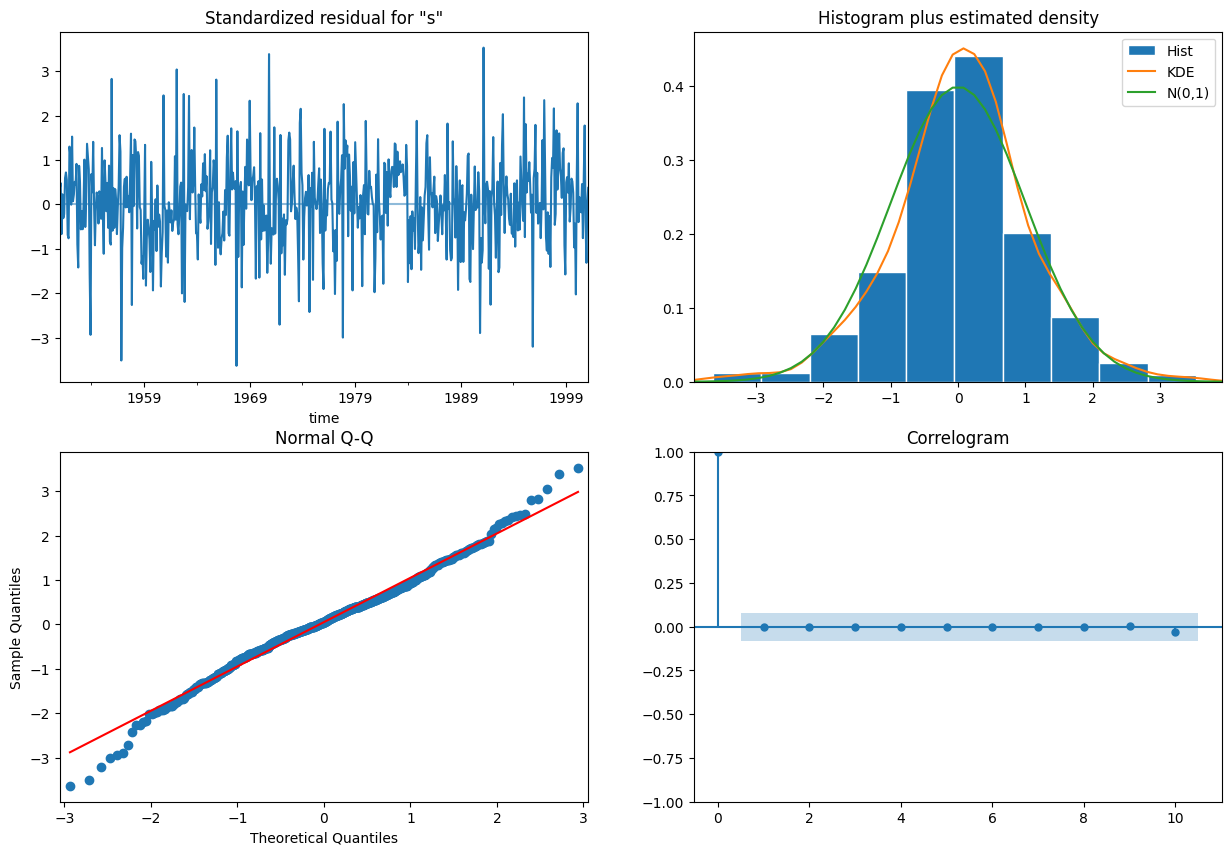

In [110]:
sarima_spei6_results.plot_diagnostics(figsize=(15, 10))
plt.show()

### Model Evaluation

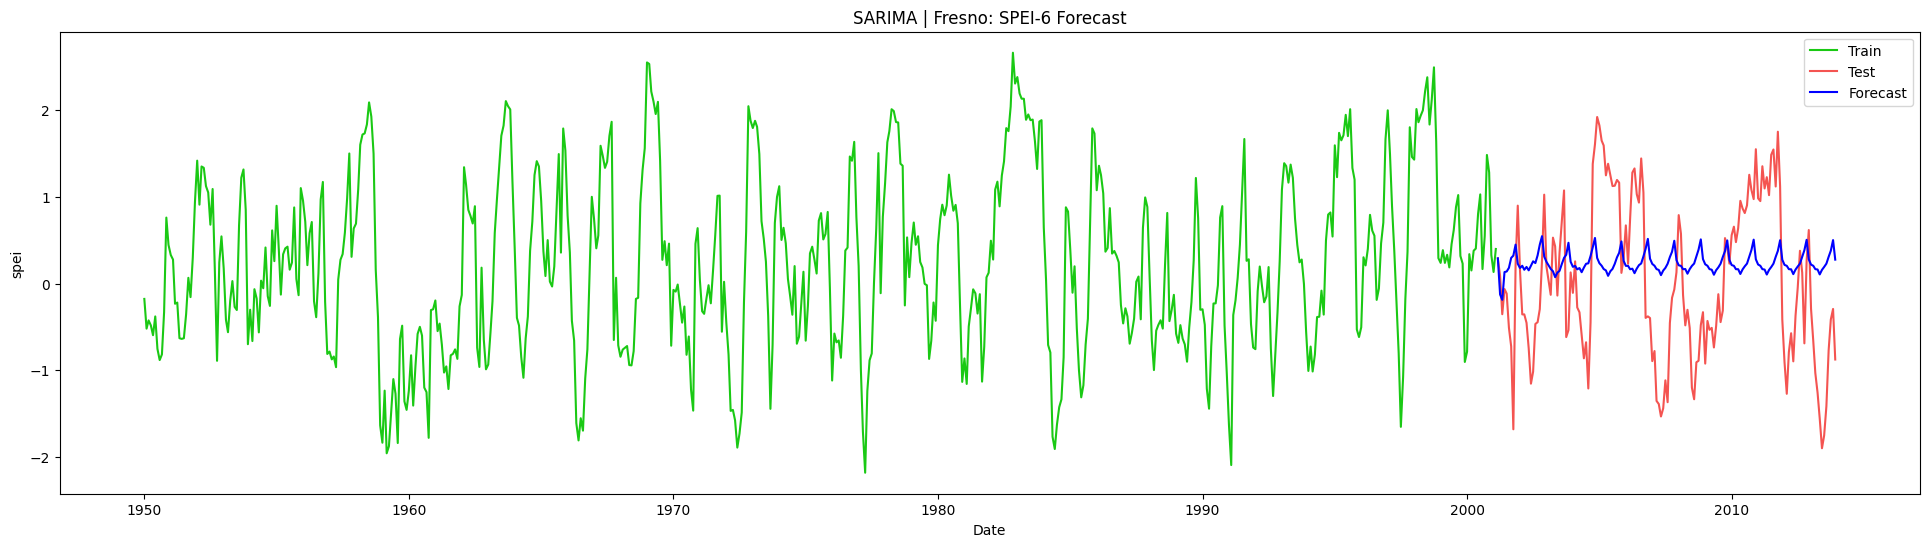

In [111]:
spei_6_forecast = sarima_spei6_results.forecast(steps=len(test_spei6_df)) # forecast

# plot the results with specified colors
plt.figure(figsize=(24,6))
plt.plot(train_spei6_df.index, train_spei6_df['spei'], label='Train', color='#1AC914')
plt.plot(test_spei6_df.index, test_spei6_df['spei'], label='Test', color='#F45451')
plt.plot(test_spei6_df.index, spei_6_forecast, label='Forecast', color='b')
plt.title('SARIMA | Fresno: SPEI-6 Forecast')
plt.xlabel('Date')
plt.ylabel('spei')
plt.legend()
plt.show()

In [107]:
spei6_mse = mean_squared_error(test_spei6_df['spei'], spei_6_forecast)
spei6_mae = mean_absolute_error(test_spei6_df['spei'], spei_6_forecast)
spei6_rmse = np.sqrt(spei6_mse)

print(f'Mean Squared Error (MSE): {spei6_mse}')
print(f'Mean Absolute Error (MAE): {spei6_mae}')
print(f'Root Mean Squared Error (RMSE): {spei6_rmse}')

Mean Squared Error (MSE): 0.8447230067945288
Mean Absolute Error (MAE): 0.7964869050144138
Root Mean Squared Error (RMSE): 0.9190881387519528


In [108]:
print(f"AIC: {sarima_spei6_results.aic}")
print(f"BIC: {sarima_spei6_results.bic}")

AIC: 870.1249848387979
BIC: 939.683212193294
